In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import glob

from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.pipeline import Pipeline
%matplotlib inline

## Analytics - Part2 (Customer Segmentation)
- RFM
- Elbow method & Silhouette score
- Kmeans
- Visualization of Clusters


*******************************************************************************************************************************************************************
### RFM Segmentation
- RFM segmentation refers to a common method used for customer segmentation based on the concepts of Recency, Frequency, and Monetary Value. RFM analysis is widely used in marketing and customer analytics to identify and group customers based on their purchasing behavior.

### Load data

In [2]:
features = ['customer_unique_id', 'order_id', 'order_status', 'product_category_name', 'order_purchase_timestamp', 'payment_value']
df = pd.read_csv("./datasets/olist_master.csv")
df = df[features]
print(df.isna().sum())
print()
print(df.shape)

customer_unique_id          0
order_id                    0
order_status                0
product_category_name       0
order_purchase_timestamp    0
payment_value               0
dtype: int64

(116581, 6)


### Preprocessing & RFM Analysis

In [3]:
#preprocessing
df = df[df.order_status == 'delivered'].reset_index(drop=True)
df.order_purchase_timestamp = df.order_purchase_timestamp.str.slice(0,10)
df['created_at'] = df.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format = "%Y-%m-%d"))
df.drop_duplicates(inplace=True)
df.head()

,customer_unique_id,order_id,order_status,product_category_name,order_purchase_timestamp,payment_value,created_at
0,5ee8fe956c2631afc0a1dcc1920d0e3d,00010242fe8c5a6d1ba2dd792cb16214,delivered,Cool Stuff,2017-09-13,72.19,2017-09-13
1,8b3f917f4307d3e5cf34c0b43d6e6f50,130898c0987d1801452a8ed92a670612,delivered,Cool Stuff,2017-06-28,73.86,2017-06-28
2,69ba88e17ea574da9c9b8c8834a583d1,532ed5e14e24ae1f0d735b91524b98b9,delivered,Cool Stuff,2018-05-18,83.23,2018-05-18
3,cbe063493a222cb17024ff0285b4ecb6,6f8c31653edb8c83e1a739408b5ff750,delivered,Cool Stuff,2017-08-01,75.07,2017-08-01
4,ffab5330bd7b40979ab6726b2e02292e,7d19f4ef4d04461989632411b7e588b9,delivered,Cool Stuff,2017-08-10,72.19,2017-08-10


- RFM calculation & Distributions

In [15]:
class calculate_rfm():
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.df.created_at = pd.to_datetime(self.df.created_at)
        
    def calculate_rfm_modified(self):        
        data = df.sort_values(by=['customer_unique_id', 'created_at'])
        # frequency
        df_tmp = data[['customer_unique_id', 'created_at']].copy().drop_duplicates()
        df_tmp['rn'] = df_tmp.groupby('customer_unique_id')['created_at'].cumcount() + 1 
        df_tmp['rn_idx'] = df_tmp.rn - 1
        df_freq_tmp = pd.merge(df_tmp, df_tmp,
                               left_on=['customer_unique_id', 'rn'],
                               right_on=['customer_unique_id', 'rn_idx'],
                               how='left')
        df_freq_tmp['frequency'] = (df_freq_tmp.created_at_y - df_freq_tmp.created_at_x).dt.days
        df_rfm = df_freq_tmp.groupby('customer_unique_id', as_index=False).frequency.mean().fillna(0)
        
        # order_count, monetary, nproduct
        df_rfm = pd.merge(df_rfm,
                          data.groupby('customer_unique_id', as_index=False).agg(monetary=('payment_value', 'sum')),
                          on='customer_unique_id',
                          how='left')
        
        # recency
        df_rfm = pd.merge(df_rfm, 
                          data.groupby('customer_unique_id', as_index=False).agg(recency=('created_at', 'max')),
                          on = 'customer_unique_id',
                          how = 'left')
        df_rfm['recency'] = (data.created_at.max() - df_rfm.recency).dt.days
        
        df_rfm = df_rfm.set_index('customer_unique_id')
        
        return df_rfm
    
    def viz_rfm(self, rfm):
        plt.figure(figsize = (18, 16))
        
        plt.subplot(3,1,1)
        sns.distplot(rfm.recency)
        # plt.title("Distribution of Recency")

        plt.subplot(3,1,2)
        sns.distplot(rfm.frequency)
        # plt.title('Distribution of Frequency')

        plt.subplot(3,1,3)
        sns.distplot(rfm.monetary)
        # plt.title("Distribution of Monetary")
        
        plt.show()

In [16]:
rfm_class = calculate_rfm(df)
df_rfm = rfm_class.calculate_rfm_modified()
df_rfm.head()

,frequency,monetary,recency
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,111.0,136.26,169
0000f46a3911fa3c0805444483337064,134.0,583.87,125
0004bd2a26a76fe21f786e4fbd80607f,218.5,336.11,7
00050ab1314c0e55a6ca13cf7181fecf,0.0,80.18,219
0005ef4cd20d2893f0d9fbd94d3c0d97,0.0,187.91,481


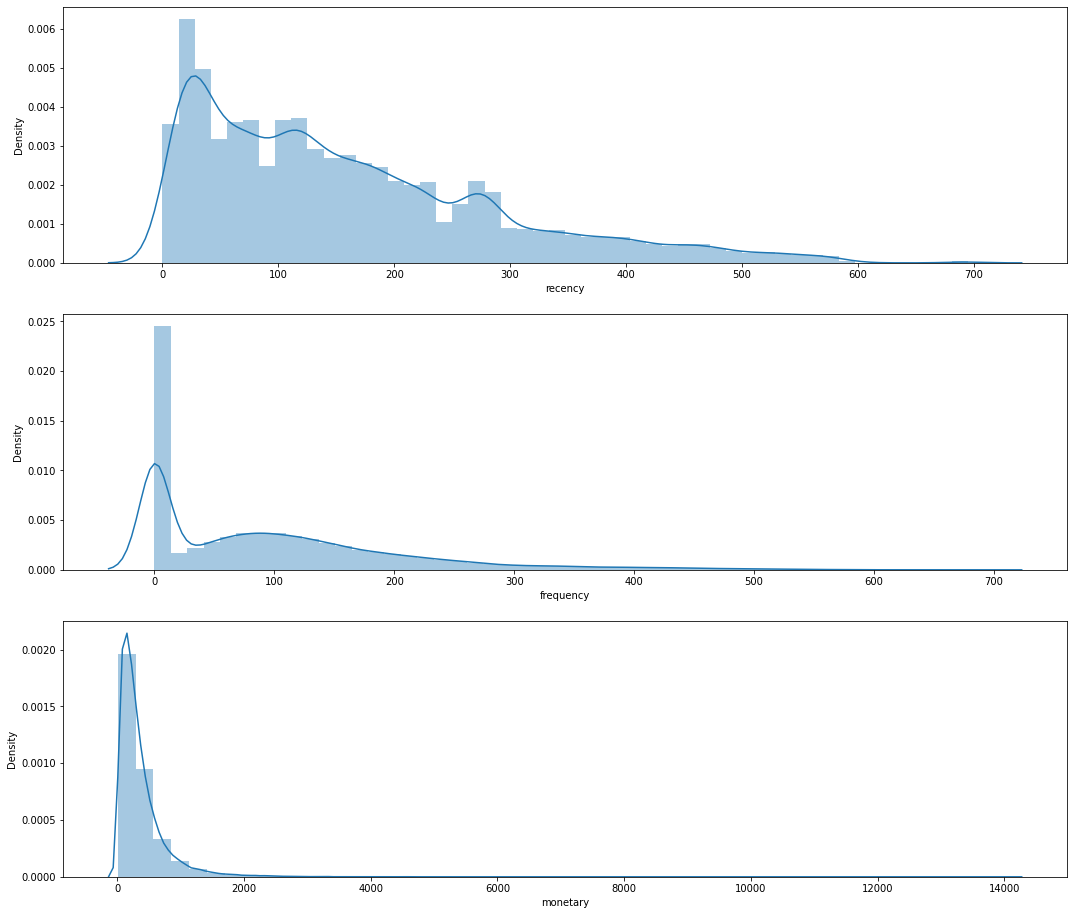

In [17]:
rfm_class.viz_rfm(df_rfm)

### Elbow method & silhouette score to find the optimal $k$ 

In [24]:
class Segmentation():
    def __init__(self, df_rfm: pd.DataFrame):
        self.df_rfm = df_rfm

    def scaler(self):
        scaler = StandardScaler()
        scaled_rfm = scaler.fit_transform(df_rfm)
        scaled_rfm = pd.DataFrame(scaled_rfm, index=df_rfm.index, columns=df_rfm.columns)
        return scaled_rfm
    
    def elbow_plot(self, scaled_df):
        kmeans_per_k = [KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42).fit(scaled_df) for k in range(1,10)]
        wcss = [model.inertia_ for model in kmeans_per_k]        
        plt.figure(figsize=(12, 9))
        plt.plot(range(1,10), wcss, 'bo-')
        plt.xlabel('$k$', fontsize=14)
        plt.ylabel('$wcss$', fontsize=14)
        plt.show()

    def silhouette_score(self, scaled_df):
        kmeans_per_k = [KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42).fit(scaled_df) for k in range(1,10)]
        silhouette_scores = [silhouette_score(scaled_df, model.labels_) for model in kmeans_per_k[1:]]
        plt.figure(figsize=(12,9))
        plt.plot(range(2,10), silhouette_scores, 'bo-')
        plt.xlabel("$k$", fontsize=14)
        plt.ylabel('silhouette score', fontsize=14)
        plt.show()

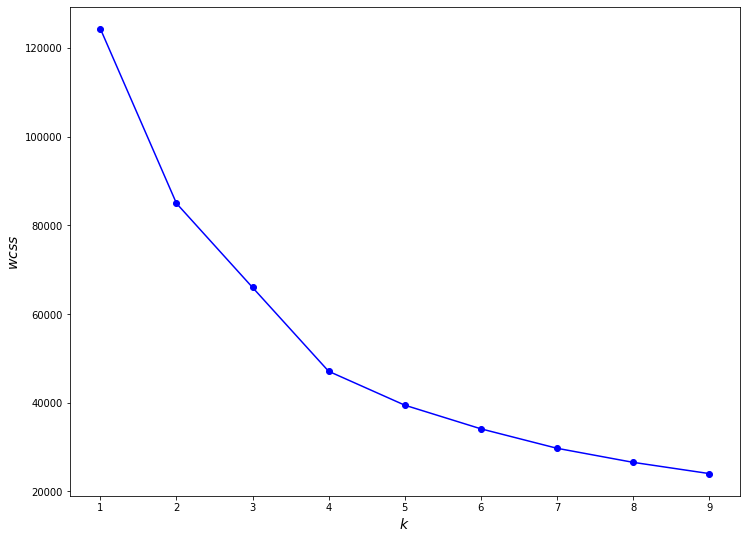

In [25]:
seg = Segmentation(df_rfm)
scaled_df = seg.scaler()
seg.elbow_plot(scaled_df)

- In the above elbow plot, 4 seems to be the optimal value for $k$, but let's double check with the silhouette score

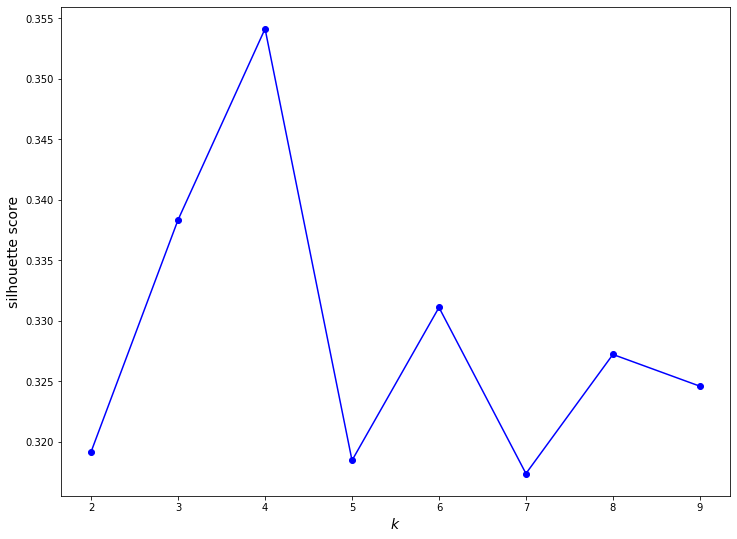

In [26]:
seg.silhouette_score(scaled_df)

- As expected, when $k=4$, the model achieved the maximum silhouette score so let's do the clustering with the $k=4$

### Implement clustering with the optimal k

In [52]:
#scaling
scaler = StandardScaler()
normalized_rfm = scaler.fit_transform(df_rfm)
normalized_rfm = pd.DataFrame(normalized_rfm, index=df_rfm.index, columns=df_rfm.columns)
normalized_rfm
#kmeans
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(normalized_rfm)
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

- Now, we got the final four clusters (0, 1, 2, 3)

In [55]:
df_clusters = df_rfm.assign(cluster=kmeans.labels_)
df_clusters

,frequency,monetary,recency,cluster
customer_unique_id,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,111.0,136.26,169,0
0000f46a3911fa3c0805444483337064,134.0,583.87,125,0
0004bd2a26a76fe21f786e4fbd80607f,218.5,336.11,7,2
00050ab1314c0e55a6ca13cf7181fecf,0.0,80.18,219,3
0005ef4cd20d2893f0d9fbd94d3c0d97,0.0,187.91,481,3
...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,188.0,1643.43,162,1
fffb09418989a0dbff854a28163e47c6,0.0,329.38,293,3
fffbf87b7a1a6fa8b03f081c5f51a201,209.0,199.50,51,2


### Calculate relative importance of each features (RFM) in each cluster

In [58]:
df_grouped = df_clusters.groupby(['cluster']).agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':'mean'
})
df_grouped

,recency,frequency,monetary
cluster,,,
0,102.074442,63.589655,312.435149
1,104.257726,106.967267,1354.800691
2,97.901310,265.623301,320.361553
3,343.591556,24.287498,195.598995


In [63]:
df_rfm = df_rfm[['recency', 'frequency', 'monetary']]
relative_importance = df_grouped / df_rfm.mean() - 1
relative_importance

,recency,frequency,monetary
cluster,,,
0,-0.363590,-0.347209,-0.159605
1,-0.349977,0.098092,2.644175
2,-0.389608,1.726804,-0.138284
3,1.142213,-0.750672,-0.473873
